# Getting started with Redistributor

Redistributor package contains three main classes:

* LearnedDistribution (estimating density from 1D data - linear model)
* KernelDensity (estimating density from 1D data - gaussian kernel)
* Redistributor (computing the transformation from one 1D density to another)

In this notebook, we demonstrate the basic usage of the aforementioned classes. \
As this package is still in development, please consult the docstrings of each class for more info.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from redistributor import Redistributor as R
from redistributor import LearnedDistribution as L
from redistributor import KernelDensity as KDE
from redistributor import plot_cdf_ppf_pdf as cpp

## Demonstrating LearnedDistribution

On the following lines, we will generate random 1D vectors of desired size form desired distribution and use LearnedDistribution class to estimate this distribution only given the data. Then we plot the pdf, cdf, ppf and histograms to compare the learned distribution with the original.

In [3]:
# Configure the size of the random data
GB = 0.10
dtype = np.float64
size = int(GB * 1024**3 / dtype().itemsize)

In [4]:
# Source distribution DGAMMA
from scipy.stats import dgamma
dist = dgamma(7.)
dist.name = 'Dgamma'
x = dist.rvs(size=size, random_state=42).astype(dtype)
a = None # np.floor(x.min())
b = None # np.ceil(x.max())
print('Input data generated.')

Input data generated.


In [5]:
# Source distribution UNIFORM
from scipy.stats import uniform
dist = uniform(loc=0., scale=1.)
dist.name = 'Uniform'
x = dist.rvs(size=size).astype(dtype)
a = None # np.floor(x.min())
b = None # np.ceil(x.max())
print('Input data generated.')

Input data generated.


In [6]:
# Source distribution GAUSSIAN
from scipy.stats import norm
dist = norm(loc=0., scale=1.)
dist.name = 'Gaussian'
x = dist.rvs(size=size).astype(dtype)
a = None #np.floor(x.min())
b = None #np.ceil(x.max())
print('Input data generated.')

Input data generated.


In [8]:
# Learned distribution config
conf = {
    'bins': None,
    'keep_x_unchanged': True,
    'subsample_x': None,
    'assume_sorted': False,
    'fill_value': 'auto',
    'resolve_duplicates': ('max', 'raise'),
    'bounds_error': 'warn',
    'seed': 42,
    'name': 'LearnedDistribution',
}

CPU times: user 856 ms, sys: 2.19 ms, total: 859 ms
Wall time: 858 ms
LearnedDistribution on interval (None, None) from Gaussian


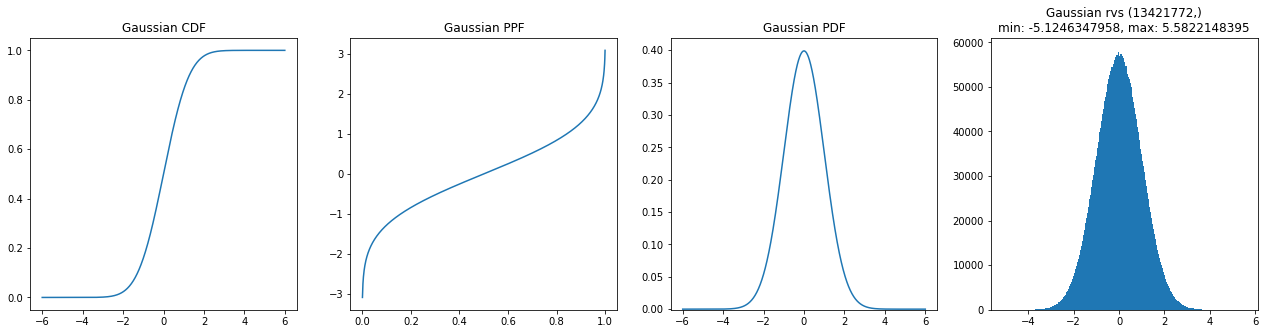

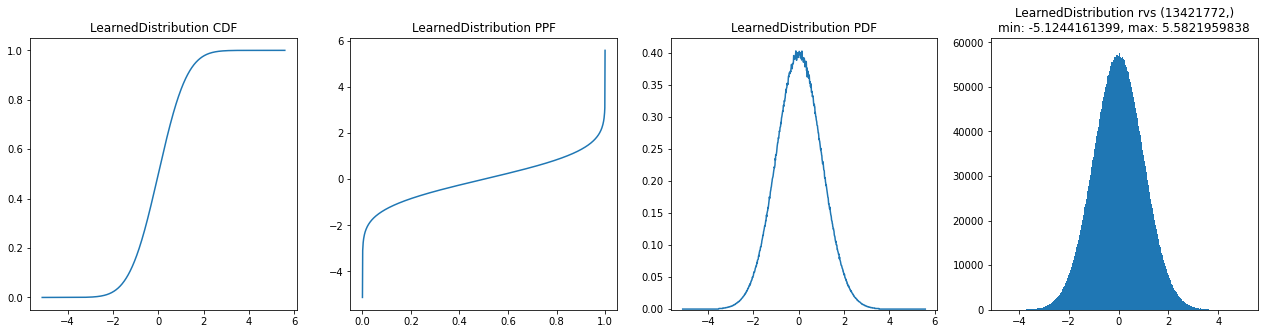

In [9]:
%time learned = L(x, a, b, **conf)
print(f'{learned.name} on interval ({learned.a}, {learned.b}) from {dist.name}')

# Show CDF, PPF, PDF and histogram of dist
plt.figure(figsize=(22,5))
cpp(dist, a=np.floor(x.min()), b=np.ceil(x.max()), v=0, w=1, bins=1000, 
    rows=1, cols=4, figsize=None)
plt.subplot(1, 4, 4)
plt.title(f'{dist.name} rvs {x.shape}\nmin: {x.min():.10f}, max: {x.max():.10f}')
plt.hist(x, bins=1000)
plt.xlim(a, b)
plt.show(); plt.close()

# Show CDF, PPF, PDF and histogram of learned
plt.figure(figsize=(22,5))
s = learned.rvs(x.size)
cpp(learned, bins=1000, rows=1, cols=4, figsize=None)
plt.subplot(1, 4, 4)
plt.title(f'{learned.name} rvs {s.shape}\nmin: {s.min():.10f}, max: {s.max():.10f}')
plt.hist(x, bins=1000)
plt.xlim(*learned._get_support())
plt.show(); plt.close()

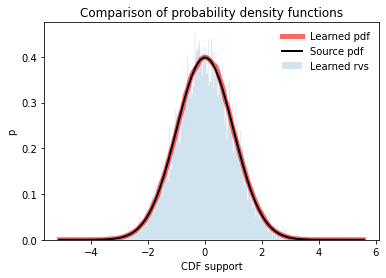

In [11]:
fig, ax = plt.subplots(1, 1)
plt.title('Comparison of probability density functions')

# Display the probability density function (PDF):
x = np.linspace(*learned._get_support(), 100)
ax.plot(x, learned.pdf(x), 'r-', lw=5, alpha=0.6, label='Learned pdf')
ax.plot(x, dist.pdf(x), 'k-', lw=2, label='Source pdf')
plt.xlabel('CDF support')
plt.ylabel('p')

# Compare the PDFs with histogram of random sample:
rs = learned.rvs(size=10000)
ax.hist(rs, bins=300, density=True, histtype='stepfilled', alpha=0.2, label='Learned rvs')

ax.legend(loc='best', frameon=False)
plt.show()

## Demonstrating KernelDensity

Already implemented, but still needs an example here. TODO

## Demonstrating Redistributor 
**With LearnedDistribution as both source and target**

Bellow, we demonstrate how to use Redistributor to transform data from source to target distribution.
In this example, we use LearnedDistribution as an estimator of the underlying data distributions of vectors x and y.
Vector x is a random sample from Dgamma distribution. Vectory y is a random sample from Gaussian distribution. 
In this example, we are looking for a transformation from source distribution given by x, into target distribution given by y.
In the end, we apply the transformation to the vector x and show, using the histogram, that the transformed vector indeed follows the Gaussian distribution.

In [12]:
# Configure the size of the random data
GB = 0.01
dtype = np.float64
size = int(GB * 1024**3 / dtype().itemsize)

In [13]:
# Source distribution 
from scipy.stats import dgamma
source_name = 'Learned dgamma'
x = dgamma(5.).rvs(size=size).astype(dtype)
source_a = None # np.floor(x.min())
source_b = None # np.ceil(x.max())
print('Source data generated.')

Source data generated.


In [14]:
# Target distribution
from scipy.stats import norm
target_name = 'Learned gaussian'
y = norm(loc=0., scale=1.).rvs(size=size).astype(dtype)
target_a, target_b = None, None # np.floor(y.min()), np.ceil(y.max()) 
print('Target data generated.')

Target data generated.


Distributions learned and Redistributor ready.
KstestResult(statistic=0.4586739483162414, pvalue=0.0)


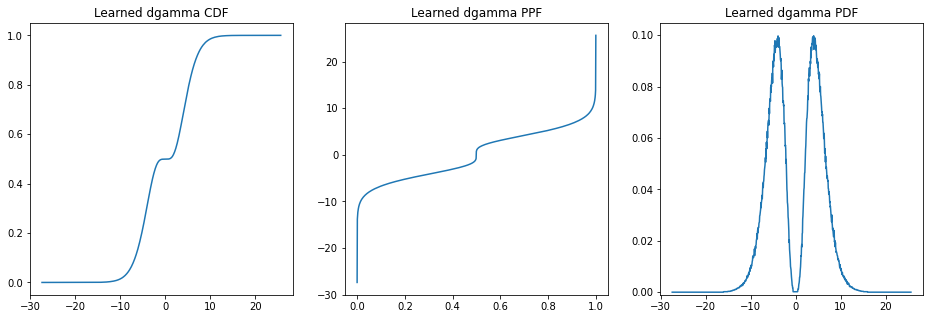

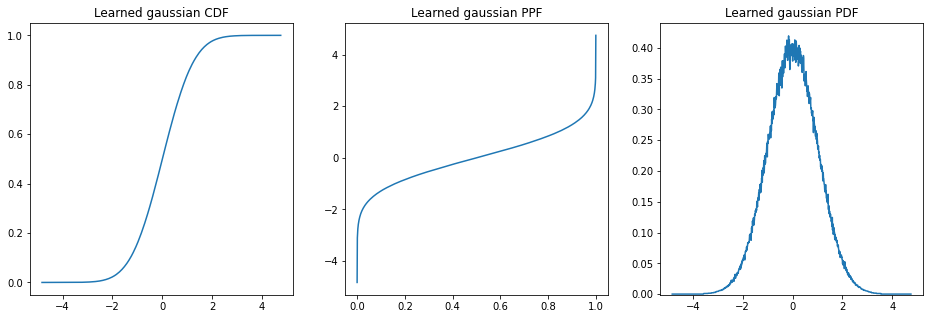

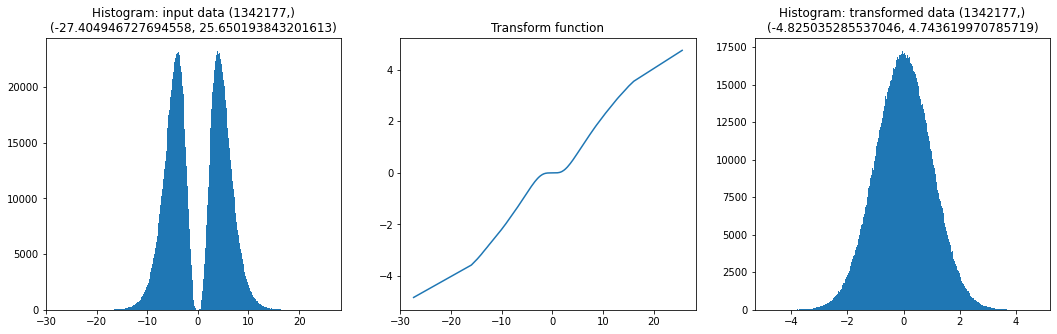

In [16]:
# Make an instance of Redistributor
r = R(
    source=L(x, source_a, source_b, name=source_name, subsample_x=None, resolve_duplicates=('max', 'raise'), bounds_error=False, fill_value='auto'),
    target=L(y, target_a, target_b, name=target_name, subsample_x=None, resolve_duplicates=('max', 'raise'), bounds_error=False, fill_value='auto'))
print('Distributions learned and Redistributor ready.')

# Use Kolmogorov-Smirnov test to find out whether it is even necessary to redistribute
print(r.kstest(n=2000)) # p-value: 0 = redistribute, 1 = no need to

# Plot the learned functions
cpp(r.source, bins=1000)
cpp(r.target, bins=1000)

# Plot the histogram of the input data before transformation
plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.hist(x, bins=300)
plt.title(f'Histogram: input data {x.shape}\n{x.min(), x.max()}')
plt.xlim(source_a, source_b)

# Plot the transform function
plt.subplot(132)
r.plot_transform_function(newfig=False)

# Plot the histogram of the transformed data
t = r.transform(x)
plt.subplot(133)
plt.hist(t, bins=300)
plt.title(f'Histogram: transformed data {t.shape}\n{t.min(), t.max()}')
plt.show()

## Demonstrating Redistributor 
**With KernelDensity as both source and target**

In this example, we use KernelDensity as an estimator of the underlying data distributions of vectors x and y.
Please note, that KernelDensity is much slower than LearnedDistribution and should be used only on smaller data sets.

In [17]:
# Configure the size of the random data
GB = 0.0001
dtype = np.float64
size = int(GB * 1024**3 / dtype().itemsize)

In [18]:
# Source distribution 
from scipy.stats import dgamma
source_name = 'KDE dgamma'
x = dgamma(5.).rvs(size=size).astype(dtype)
source_a = None # np.floor(x.min())
source_b = None # np.ceil(x.max())
print('Source data generated.')

Source data generated.


In [19]:
# Target distribution
from scipy.stats import norm
target_name = 'KDE gaussian'
y = norm(loc=0., scale=1.).rvs(size=size).astype(dtype)
target_a, target_b = None, None # np.floor(y.min()), np.ceil(y.max()) 
print('Target data generated.')

Target data generated.


Distributions learned and Redistributor ready.
KstestResult(statistic=0.3893389932111309, pvalue=1.624196933893977e-273)


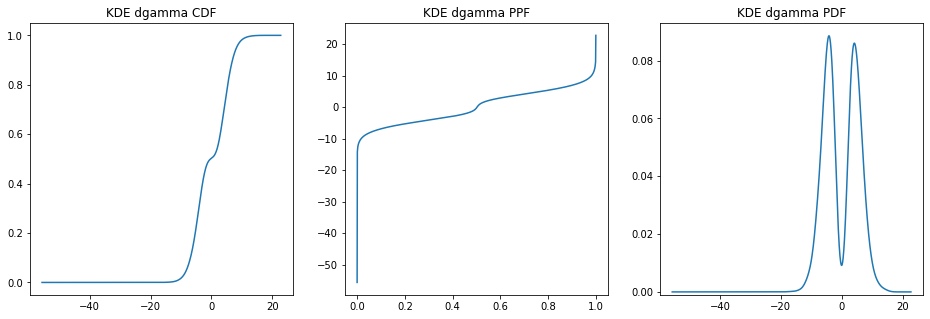

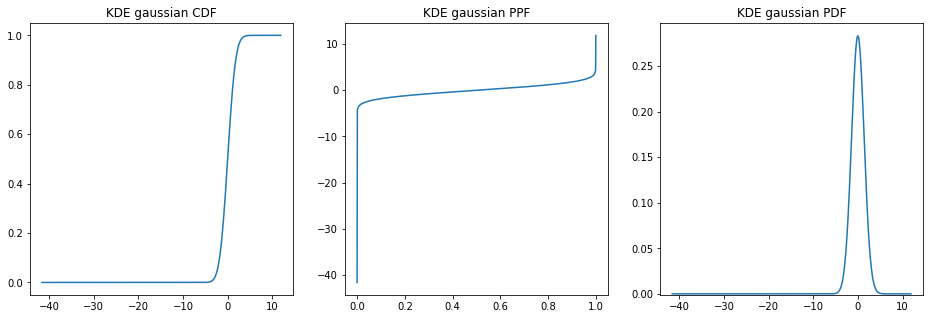

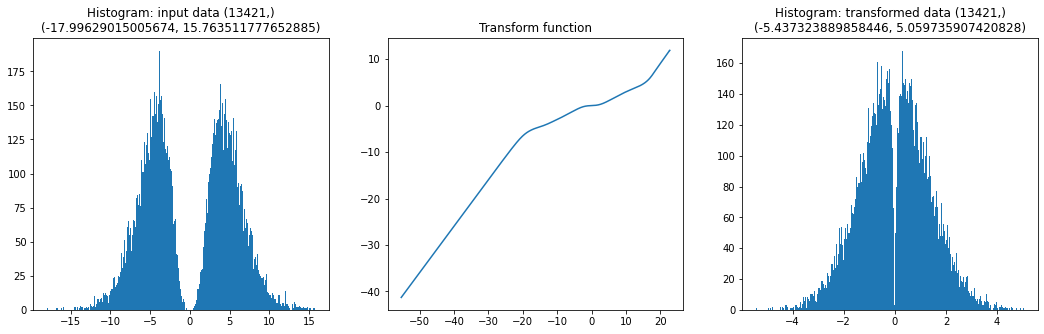

In [20]:
# Make an instance of Redistributor
r = R(source=KDE(x, name=source_name, cdf_method='fast'), 
      target=KDE(y, name=target_name, cdf_method='fast'))
print('Distributions learned and Redistributor ready.')

# Use Kolmogorov-Smirnov test to find out whether it is even necessary to redistribute
print(r.kstest(n=2000)) # p-value: 0 = redistribute, 1 = no need to

# Plot the learned functions
cpp(r.source, bins=1000)
cpp(r.target, bins=1000)

# Plot the histogram of the input data before transformation
plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.hist(x, bins=300)
plt.title(f'Histogram: input data {x.shape}\n{x.min(), x.max()}')
plt.xlim(source_a, source_b)

# Plot the transform function
plt.subplot(132)
r.plot_transform_function(newfig=False)

# Plot the histogram of the transformed data
t = r.transform(x)
plt.subplot(133)
plt.hist(t, bins=300)
plt.title(f'Histogram: transformed data {t.shape}\n{t.min(), t.max()}')
plt.show()